In [6]:
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
import gdsfactory as gf
import sax
import gplugins.sax as gs
import lnoi400

### Circuit simulation of a splitter tree

We build a simple, two-level-deep splitter tree, creating a new gdsfactory hierarchical component. 

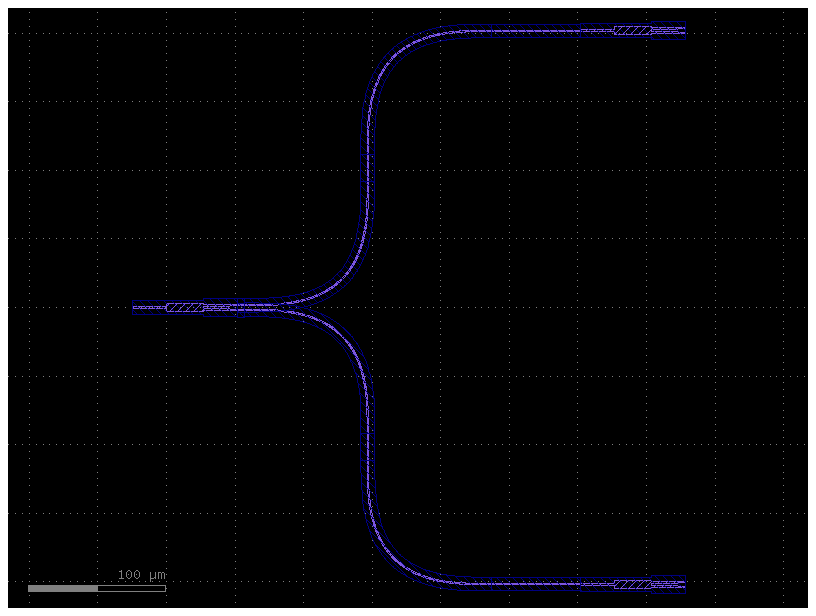

In [7]:
@gf.cell
def splitter_chain(
    splitter = gf.get_component("mmi1x2_optimized1550"),
    column_offset = (250.0, 200.0),
    routing_reff = 90.0
) -> gf.Component:

    c = gf.Component()
    s0 = c << splitter
    s01 = c << splitter
    s02 = c << splitter
    s01.dmove(
        s01.ports["o1"].dcenter,
        s0.ports["o2"].dcenter + np.array(column_offset)
    )
    s02.dmove(
        s02.ports["o1"].dcenter,
        s0.ports["o3"].dcenter + np.array([column_offset[0], - column_offset[1]])
    )

    # Bend spec

    routing_bend = gf.get_component('L_turn_bend', radius=routing_reff)

    # Routing between splitters

    for ports_to_route in [
        (s0.ports["o2"], s01.ports["o1"]),
        (s0.ports["o3"], s02.ports["o1"]),
    ]:

        gf.routing.route_single(
            c,
            ports_to_route[0],
            ports_to_route[1],
            start_straight_length=5.0,
            end_straight_length=5.0,
            cross_section="xs_rwg1000",
            bend=routing_bend,
        )

    # Expose the I/O ports

    c.add_port(name="in", port=s0.ports["o1"])
    c.add_port(name="out_00", port=s01.ports["o2"])
    c.add_port(name="out_01", port=s01.ports["o3"])
    c.add_port(name="out_10", port=s02.ports["o2"])
    c.add_port(name="out_11", port=s02.ports["o3"])

    return c

chain = splitter_chain()
chain

Let's compile the circuit simulation using sax.

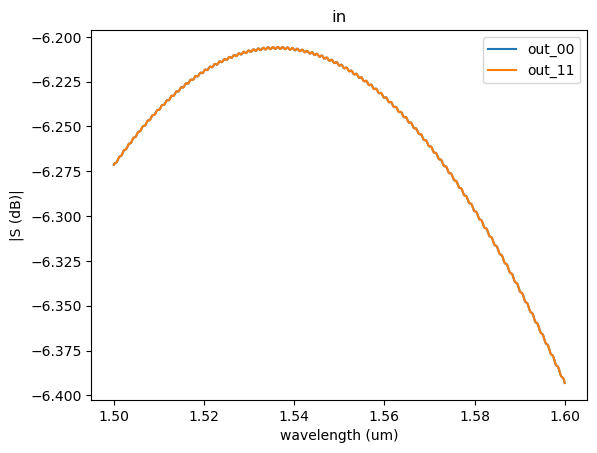

In [8]:
nl = chain.get_netlist()
pcell_models = lnoi400.get_models()

models = {
    # The Euler bend should be sufficiently low-loss to be approximated with a straight waveguide
    # (if the frequency is not too low)
    "L_turn_bend": pcell_models["straight_rwg1000"], 
    "straight": pcell_models["straight_rwg1000"],
    "mmi1x2_optimized1550": pcell_models["mmi1x2_optimized1550"],
}
circuit, _ = sax.circuit(netlist=nl, models=models)

_ = gs.plot_model(
    circuit,
    wavelength_start=1.5,
    wavelength_stop=1.6,
    port1="in",
    ports2=("out_00", "out_11"),
)

### Simulation of a Mach-Zehnder interferometer with a thermo-optical phase shifter

First we take a look at the cell layout.

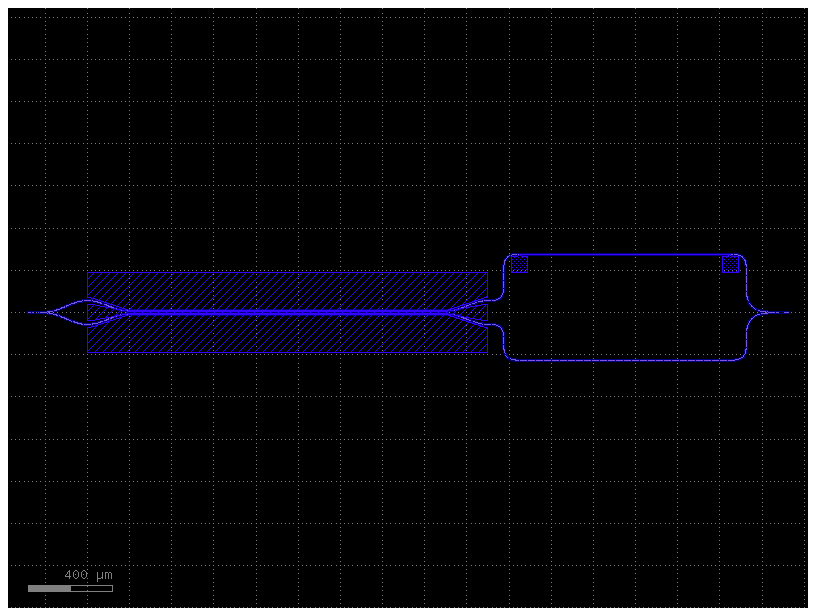

In [9]:
mzm_specs = dict(
    modulation_length=1500.0,
    with_heater=True,
    bias_tuning_section_length=1000.0,
)
mzm = gf.get_component(
    "mzm_unbalanced",
    **mzm_specs,
    )
mzm.plot()

Then, we retrieve the circuit model and evaluate it for different wavelengths and voltages.

Text(0, 0.5, 'MZM transmission')

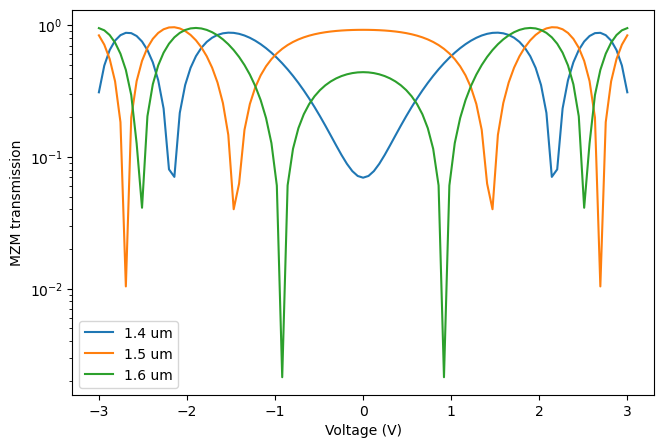

In [10]:
mzm_specs = dict(
    modulation_length=1500.0,
    heater_length=1000.0,
)
mzm_model = partial(
    pcell_models["mzm_unbalanced"],
    **mzm_specs,
)

fig = plt.figure(figsize=(7.5, 5))

wls = [1.4, 1.5, 1.6]
V_scan = np.linspace(-3, 3, 99)
for wl in wls:
    P_out = [np.abs(mzm_model(
        wl=wl,
        V_ht=V,
        )["o2", "o1"])
        for V in V_scan]
    plt.semilogy(V_scan, P_out, label=f'{wl} um')

plt.legend(loc='best')
plt.xlabel("Voltage (V)")
plt.ylabel("MZM transmission")